In [1]:
import numpy as np
from collections import Counter
from itertools import product
from qiskit import *
from qiskit.algorithms.optimizers import SPSA
import matplotlib.pyplot as plt
import seaborn as sns
from utils import SPSACallback
import scipy as sp

plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams["font.size"] = 25
RANDOM_STATE = 101
np.random.seed(RANDOM_STATE)

# 1. Generating  random data 

We begin by simulating a gaussian copula. We can use arbitray marginals, but for the sake of simulation they are also gaussian in this case. Then, we are effectively modeling a gaussian multivariate distribution.
Recall that the U-copula space is U ~ F(X) where X is our original data and F(·) the gaussian CDF.

In [2]:
from generate_data import gaussian_copula,convert_data_to_binary_string,empirical_distribution

# Correlation  matrices
P_3 = np.array([[ 1.0, 0.3,  0.2],
              [0.3,  1.0,  0.7],
              [ 0.2,  0.7,  1.0]])

# Gaussian copula parameters
rho = 0.7
mu_c = np.array([0,0])
cov_c = np.array([[1,rho],[rho,1]])
NUM_TRAINING_SAMPLES = 10000

# Problem dimensions
NUM_QUBITS_VAR = 3
NUM_VARS = len(cov_c)

# U represents the pseudo-samples space of the data and G represents a multivariate gaussian distribution 
# after doing the inverse probability integral transform.
Z, U, G = gaussian_copula(mu_c,cov_c,NUM_TRAINING_SAMPLES)

# Binary strings encoding of the training dataset U
binary_samples = convert_data_to_binary_string(U,NUM_QUBITS_VAR)
# Generate the target distribution obver the binary strings of training dataset
target_probs = empirical_distribution(binary_samples, NUM_QUBITS_VAR*NUM_VARS)

## The marginals and joint distribution of the U-copula space (pseudo-samples in the paper)

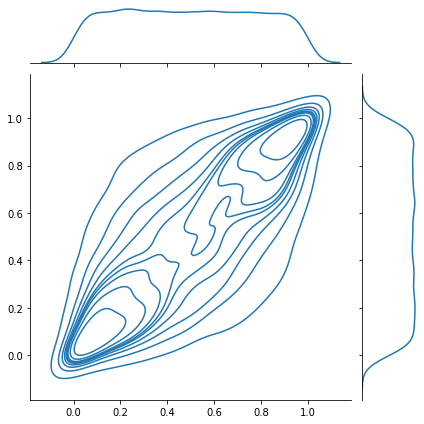

In [3]:
sns.jointplot(x=U[:,0], y=U[:,1], kind="kde");

## The marginals and joint distribution of the simulated data after applying the inverse probability transform integral in the copula space

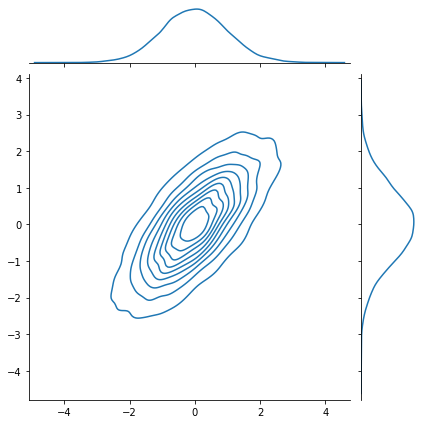

In [4]:
sns.jointplot(x=G[:,0], y=G[:,1], kind="kde");

## Estimate pearson correlation of the U-copula space samples

In [5]:
np.corrcoef(U,rowvar=False)

array([[1.        , 0.67997298],
       [0.67997298, 1.        ]])

# 2. Hybrid quantum-classical optimization loop

In [6]:
# Model input parameters and optimization config
NUM_LAYERS = 2
NUM_SHOTS = 3000
NUM_ITERS = 600
spsa_cbk = SPSACallback()
spsa = SPSA(maxiter=NUM_ITERS,callback=spsa_cbk.callback,learning_rate = 0.1,perturbation=0.1)

## Optimizing the QCBM model

In [ ]:
from qcbm import QCBM
import time

qcbm_model = QCBM(NUM_QUBITS_VAR,NUM_VARS,NUM_LAYERS,NUM_SHOTS,target_probs)
cost_function = qcbm_model.cost_function
initial_params = np.pi*np.random.rand(3, NUM_QUBITS_VAR*NUM_VARS, NUM_LAYERS).flatten()
start = time.time()
result = spsa.minimize(cost_function, initial_params)
end = time.time()
print("The optimization took : {} secs after {} epochs".format(end-start,NUM_ITERS))

## Visualizing the loss curve

In [ ]:
plt.rcParams["figure.figsize"] = (20,15)
plot_data = spsa_cbk.get_callback_data() 
plt.plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
plt.xlabel("Number of iterations",fontsize=15)
plt.ylabel("Kullback divergence loss",fontsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

## Comparing learned and target distributions

In [ ]:
# Evaluate trained probability distribution by comapring histograms 
plt.rcParams["figure.figsize"] = (40,15)
bounds = [0,1]
num_qubits = NUM_QUBITS_VAR*NUM_VARS

x = [bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)]

opt_params = result.x
y = qcbm_model.estimate_distribution(opt_params,num_shots= 10000)

# Plot distributions
plt.bar(x, y, width=0.01, label="Learned distribution", color="royalblue")
#plt.xticks(x, size=15, rotation=45)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Pseudo-sample space", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.bar(x,target_probs,width=0.01,color="RED",label="target distribution",alpha = 0.5)
plt.legend(loc="best")
plt.show()

In [ ]:
opt_params = result.x
opt_cost = result.fun
print("Optimal cost function value: ", opt_cost)

## Sampling from the QCBM  in the trained copula space and original random sample space

In [ ]:
#import importlib
#import qcbm
#from qcbm import QCBM
#qcbm_model = QCBM(NUM_QUBITS_VAR,NUM_VARS,NUM_LAYERS,NUM_SHOTS,target_probs)
#importlib.reload(qcbm)

## The marginals and joint distribution estimated from sampling pseudo-samples from the trained QCBM model

In [ ]:
U_qcbm  = qcbm_model.sample(opt_params,num_shots= 10000)
sns.jointplot(x=U_qcbm[:,1], y=U_qcbm[:,0], kind="kde")
np.corrcoef(U_qcbm,rowvar=False)

## Inverse transformation

In [ ]:
G_qcbm = sp.stats.norm.ppf(U_qcbm)
sns.jointplot(x=G_qcbm[:,1], y=G_qcbm[:,0], kind="kde")
np.corrcoef(G_qcbm,rowvar=False)